### **Descarga e importe de bibliotecas**

In [1]:
%%capture
!pip install kagglehub

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"

In [3]:
import gc
import re
import glob
import random
import zipfile
import shutil
import kagglehub
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tf_keras as keras
from tf_keras import Model
from tf_keras.models import load_model

2025-04-11 19:13:08.961380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744398789.221991      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744398789.296424      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### **Configuración del entorno**

In [4]:
# Set a seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### **Descarga y cargado de la base de datos de mamitas**

##### **Importante definir el número de clases**

In [5]:
classes = 2 # Son dos clases; 0-Fondo, 1-feet

In [6]:
config = {"Seg_model":"ResUNet","Activation":"softmax","Input size":(512,512,3),"Image size":(512,512),
          "Dataset":"mamitas-only-subject","Dir of dataset":"/kaggle/input/mamitas-only-subject","Batch size":32,"Number of classes":classes}

In [7]:
class DataLoader:

    def __init__(self, data_dir, batch_size, image_size, num_classes, partition):

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.partition = partition

    def load_images(self):

        # Create the path for patch images
        images_path_pattern = os.path.join(self.data_dir, self.partition, 'images', '*.png')
        images_files = glob.glob(images_path_pattern)

        # Sort patch files alphanumerically
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers for proper sorting
            return [int(part) if part.isdigit() else part for part in parts]

        images_files = sorted(images_files, key=alphanumeric_key)

        self.file_sample = []
        for file in images_files:
            name_file = file.split('/')[-1]
            self.file_sample.append(name_file)

        self.num_samples = len(images_files)

        # Print the complete path and the number of found patch images
        print(f"Complete images: {images_path_pattern}")
        print(f"Number of images files found: {len(images_files)}")

        # Create a TensorFlow dataset from the images file paths
        images_ds = tf.data.Dataset.from_tensor_slices(images_files)

        # Map each file path to a processed image
        images_ds = images_ds.map(self.process_images, num_parallel_calls=tf.data.AUTOTUNE)

        return images_ds

    def load_masks(self):

        mask_path_main = os.path.join(self.data_dir, self.partition, 'masks')

        # Check samples in classes
        for class_id in range(self.num_classes):
            mask_path_pattern = os.path.join(mask_path_main, f'class_{class_id}', '*.png')
            found_masks = glob.glob(mask_path_pattern)
            print(f"Original masks path, class {class_id}: {mask_path_pattern}")
            print(f"Number of masks found: {len(found_masks)}")

        masks_path = []
        # Organize ground truth masks by sample and class
        for sample in self.file_sample:
            masks_sample = []
            for class_id in range(self.num_classes):
                masks_sample.append(os.path.join(mask_path_main, f'class_{class_id}', sample))
            masks_path.append(masks_sample)

        # Create dataset from `masks_path` and apply `process_masks` to each set of paths
        masks_ds = tf.data.Dataset.from_tensor_slices(masks_path)
        masks_ds = masks_ds.map(self.process_masks, num_parallel_calls=tf.data.AUTOTUNE)

        return masks_ds

    def process_images(self, file_path):

        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_png(img, channels=3)  # Decode PNG image
        img = tf.image.resize(img, self.image_size)  # Resize image
        img = tf.cast(img, tf.float32)  # Convert to float32
        img /= 255.0  # Normalize to [0, 1]
        return img

    def process_masks(self, sample_paths):

        # Decode and process images
        decoded_images = tf.map_fn(
            tf.io.read_file,
            sample_paths,
            dtype=tf.string,
            parallel_iterations=4
        )

        masks = tf.map_fn(
            lambda x: tf.io.decode_png(x, channels=1),
            decoded_images,
            dtype=tf.uint8,
            parallel_iterations=4
        )

        # Resize and normalize
        masks = tf.map_fn(
            lambda x: tf.image.resize(x, size=self.image_size),
            masks,
            dtype=tf.float32
        )

        masks = tf.cast(masks, tf.float32)  # Convert to float32
        masks = masks / 255.0  # Normalize to [0, 1]
        masks = tf.squeeze(masks, axis=-1)  # Remove the last dimension
        masks = tf.transpose(masks, perm=[1, 2, 0])  # Transpose to [height, width, classes]

        return masks

    def get_dataset(self):

        images_ds = self.load_images()
        masks_ds = self.load_masks()
        dataset = tf.data.Dataset.zip((images_ds,masks_ds))

        # Apply batching and prefetching for optimization
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

        return dataset

In [8]:
# Instantiate data loader and load train partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Train')
train_dataset = data_loader.get_dataset()

Complete images: /kaggle/input/mamitas-only-subject/Train/images/*.png
Number of images files found: 342


2025-04-11 19:13:39.749995: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Original masks path, class 0: /kaggle/input/mamitas-only-subject/Train/masks/class_0/*.png
Number of masks found: 342
Original masks path, class 1: /kaggle/input/mamitas-only-subject/Train/masks/class_1/*.png
Number of masks found: 342


In [9]:
# Instantiate data loader and load validation partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Valid')
valid_dataset = data_loader.get_dataset()

Complete images: /kaggle/input/mamitas-only-subject/Valid/images/*.png
Number of images files found: 37
Original masks path, class 0: /kaggle/input/mamitas-only-subject/Valid/masks/class_0/*.png
Number of masks found: 37
Original masks path, class 1: /kaggle/input/mamitas-only-subject/Valid/masks/class_1/*.png
Number of masks found: 37


In [10]:
# Instantiate data loader and load test partition
data_loader = DataLoader(config['Dir of dataset'], config['Batch size'], 
                         config['Image size'], config['Number of classes'],'Test')
test_dataset = data_loader.get_dataset()

Complete images: /kaggle/input/mamitas-only-subject/Test/images/*.png
Number of images files found: 37
Original masks path, class 0: /kaggle/input/mamitas-only-subject/Test/masks/class_0/*.png
Number of masks found: 37
Original masks path, class 1: /kaggle/input/mamitas-only-subject/Test/masks/class_1/*.png
Number of masks found: 37


### **Descarga y cargado del modelo entrenado**

In [15]:
# Descarga y carga del modelo TF Lite
# Se asume que ya has convertido y subido el modelo TF Lite a Kaggle
model_tflite_path = kagglehub.model_download("fredycastao/resunet-resnet34-mamitas-seg-tflite/tflite/default")
output_folder = "./models"
os.makedirs(output_folder, exist_ok=True)
shutil.copy(os.path.join(model_tflite_path, 'ResUNet_resnet34_Mamitas.tflite'), output_folder)
tflite_model_file = os.path.join(output_folder, 'ResUNet_resnet34_Mamitas.tflite')

In [16]:
# Cargar el modelo TF Lite
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#### **Inferencia y visualización del modelo para datos de visualización**

In [17]:
# Función para realizar inferencia con TF Lite
def predict_tflite(interpreter, input_data):
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Inferencia y visualización con el modelo TF Lite
def performance_visualization(dataset, interpreter, config):
    batch = 0
    for images, masks in dataset.skip(batch).take(1):
        print(f"Images in the batch: {images.shape}, Masks in the batch: {masks.shape}")
    sample = random.randint(0, images.shape[0] - 1)
    
    # Convertir la imagen seleccionada a un batch con dimensión extra
    input_data = np.expand_dims(images[sample].numpy(), axis=0).astype(np.float32)
    predictions = predict_tflite(interpreter, input_data)
    
    # Visualización
    columns = masks.shape[-1] if masks.shape[-1] <= 6 else 6
    rows = 3
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(rows + 1, columns, hspace=0.2, wspace=-0.6)
    axes = [[fig.add_subplot(gs[r, c]) for c in range(columns)] for r in range(rows)]
    
    axes[0][0].set_title('Image', loc='center')
    axes[0][0].imshow(images[sample])
    
    title_ax = fig.add_subplot(gs[rows-2, :])
    title_ax.set_title("Original masks for different classes", loc='center')
    title_ax.axis('off')
    
    classes_list = []
    while len(classes_list) < min(config['Number of classes'], columns):
        num = random.randint(0, config['Number of classes'] - 1)
        if num not in classes_list:
            classes_list.append(num)
    
    for i in range(len(classes_list)):
        axes[rows-2][i].imshow(masks[sample, :, :, classes_list[i]:classes_list[i]+1])
    
    title_ax = fig.add_subplot(gs[rows-1, :])
    title_ax.set_title("Predicted masks for different classes", loc='center')
    title_ax.axis('off')
    
    classes_list = []
    while len(classes_list) < min(config['Number of classes'], columns):
        num = random.randint(0, config['Number of classes'] - 1)
        if num not in classes_list:
            classes_list.append(num)
            
    for i in range(len(classes_list)):
        pred_mask = tf.where(predictions[0, :, :, classes_list[i]:classes_list[i]+1] > 0.5, 1.0, 0.0)
        axes[rows-1][i].imshow(pred_mask)
    
    for row in axes:
        for ax in row:
            ax.axis('off')
    
    fig.tight_layout()
    plt.show()
    del images, predictions, classes_list, masks
    gc.collect()

Images in the batch: (32, 512, 512, 3), Masks in the batch: (32, 512, 512, 2)


/tmp/ipykernel_31/2932117474.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


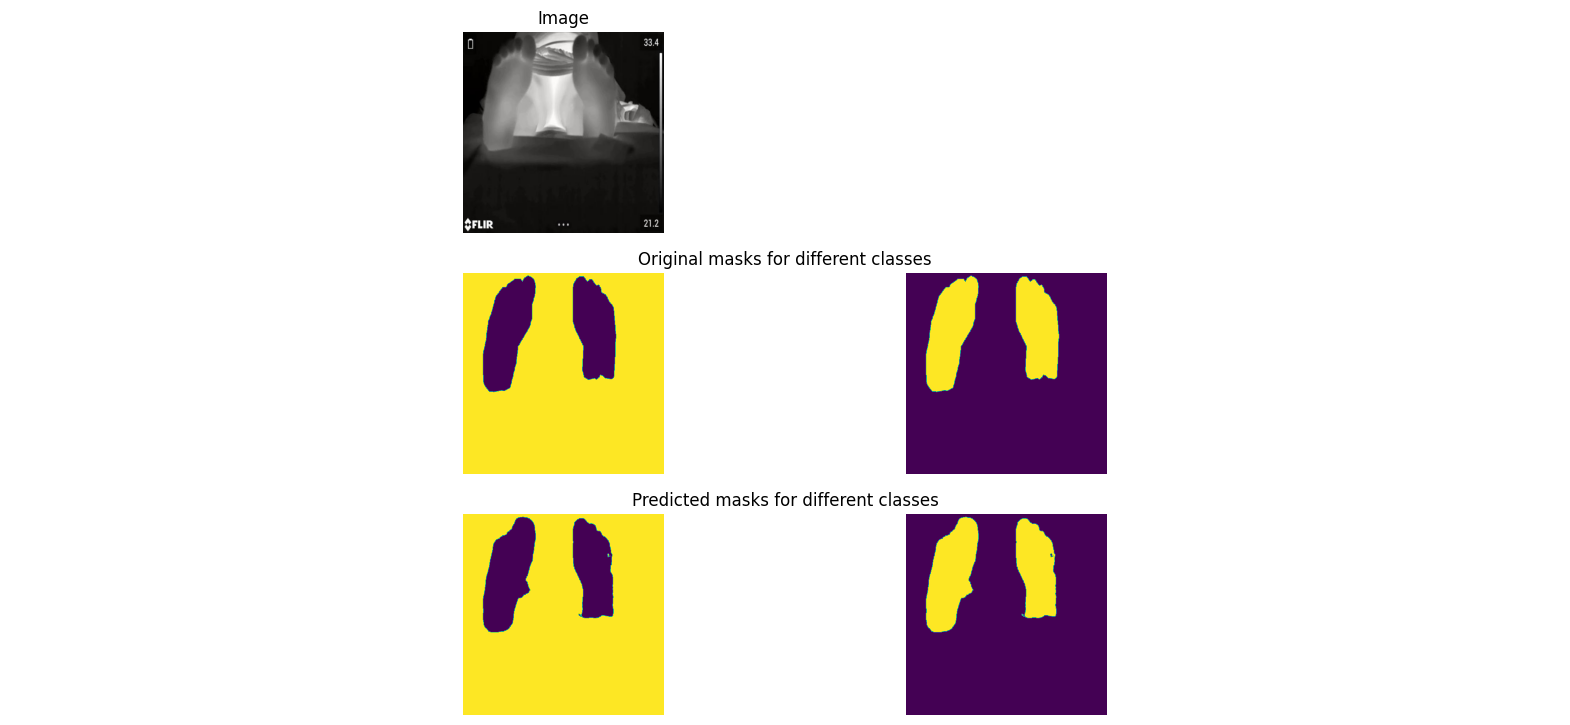

In [18]:
performance_visualization(test_dataset, interpreter, config)

##### **Hacer inferencia mediante dirección de una imagen**

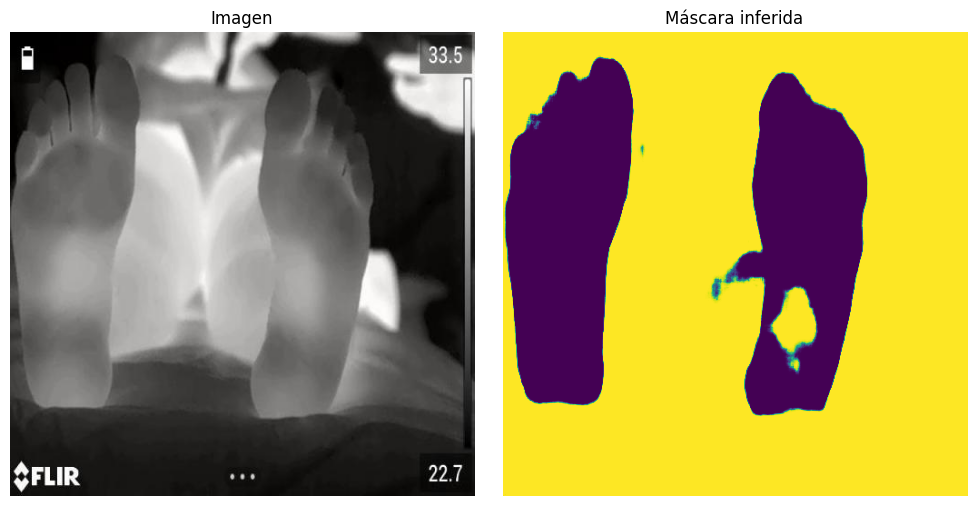

In [21]:
# Hacer inferencia mediante dirección de una imagen con TF Lite
image_path = '/kaggle/input/mamitas-only-subject/Test/images/t0_Caso4_jpg.rf.ab2da50eedb8313e26cc7df780103923.png'
image = tf.io.read_file(image_path)
image = tf.image.decode_png(image, channels=3)
image = tf.cast(image, tf.float32) / 255.0
input_image = np.expand_dims(image.numpy(), axis=0).astype(np.float32)
prediction = predict_tflite(interpreter, input_image)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title('Imagen')
axs[0].axis('off')
axs[1].imshow(prediction[0][..., 0])
axs[1].set_title('Máscara inferida')
axs[1].axis('off')
plt.tight_layout()
plt.show()